# Banking Regression Review

## Background

The intent of this excercise is to build a logistic regression model to "predict if the client will subscribe a bank term deposit (variable y)."

In addition, the following data dictionary was provided with the dataset (with formatting edits):

### bank client data:
1. age (numeric)
2. job : type of job (categorical: "admin.", "blue-collar", "entrepreneur", "housemaid", "management", "retired", "self-employed", "services", "student", "technician", "unemployed", "unknown")
3. marital : marital status (categorical: "divorced", "married", "single", "unknown"; note: "divorced" means divorced or widowed)
4. education (categorical: "basic.4y", "basic.6y", "basic.9y", "high.school", "illiterate", "professional.course", "university.degree", "unknown")
5. default: has credit in default? (categorical: "no","yes","unknown")
6. housing: has housing loan? (categorical: "no","yes","unknown")
7. loan: has personal loan? (categorical: "no","yes","unknown")
### related with the last contact of the current campaign:
8. contact: contact communication type (categorical: "cellular","telephone") 
9. month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
10. day_of_week: last contact day of the week (categorical: "mon","tue","wed","thu","fri")
11. duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
### other attributes:
12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")
### social and economic context attributes:
16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
17. cons.price.idx: consumer price index - monthly indicator (numeric)     
18. cons.conf.idx: consumer confidence index - monthly indicator (numeric)     
17. euribor3m: euribor 3 month rate - daily indicator (numeric)
20. nr.employed: number of employees - quarterly indicator (numeric)

### Output variable (desired target):
21. y - has the client subscribed a term deposit? (binary: "yes","no")

Data used for this case study and quoted information above is publically available, accessed via the UCI portal. 

Citation to the original data is below:

[Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, In press, http://dx.doi.org/10.1016/j.dss.2014.03.001

## Import Modules

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import statsmodels.api as sm
from sklearn import metrics
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

%matplotlib inline

## Import Data

In [2]:
fullDat = pd.read_csv('../data/bank-additional/bank-additional-full.csv', sep = ';')
## Change column names to be readable through

colNames = {}
for name in fullDat.columns:
    colNames[name] = name.replace('.', '_')
    
fullDat.rename(columns = colNames, inplace = True)
fullDat.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## EDA

In [3]:
## Review data structure
fullDat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp_var_rate    41188 non-null  float64
 16  cons_price_idx  41188 non-null  float64
 17  cons_conf_idx   41188 non-null 

### Review of Target

In [4]:
fullDat.y.value_counts()

no     36548
yes     4640
Name: y, dtype: int64

In [5]:
round(fullDat.y.value_counts(normalize = True),3)

no     0.887
yes    0.113
Name: y, dtype: float64

The target, as mentioned in the introduction, contains only the values yes and no. While modeling, we should consider the impact of the class imbalance. Given the imbalance isn't heavy strong, I will not move forward with a SMOTE algorithim to account for the imbalance, rather handeling this within the model parameters where possible.

### Feature Review

In [6]:
## Review distribution of NAs - looks like everything is populated
fullDat.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64

In [7]:
for columnName in fullDat.columns:
    if columnName == 'y':
        pass
    elif fullDat[columnName].dtype == object:
        print("Distribution for:", columnName)
        print(fullDat.groupby(['y', columnName]).size().reset_index(name='Count').pivot_table(index = columnName,
                                                                                 columns = 'y',
                                                                                 values = 'Count'))
        print('\n')

Distribution for: job
y                no   yes
job                      
admin.         9070  1352
blue-collar    8616   638
entrepreneur   1332   124
housemaid       954   106
management     2596   328
retired        1286   434
self-employed  1272   149
services       3646   323
student         600   275
technician     6013   730
unemployed      870   144
unknown         293    37


Distribution for: marital
y            no   yes
marital              
divorced   4136   476
married   22396  2532
single     9948  1620
unknown      68    12


Distribution for: education
y                       no   yes
education                       
basic.4y              3748   428
basic.6y              2104   188
basic.9y              5572   473
high.school           8484  1031
illiterate              14     4
professional.course   4648   595
university.degree    10498  1670
unknown               1480   251


Distribution for: default
y             no     yes
default                 
no       28391.0

Based on the distribution above, there does appear to be good distributional spread across the target between most of the categorical features outside of default. Given there are only three "yes" values and imputating the portion of unknown's would be difficult, I'll drop this from further analysis.

In [8]:
fullDat.drop('default', axis = 1, inplace = True)

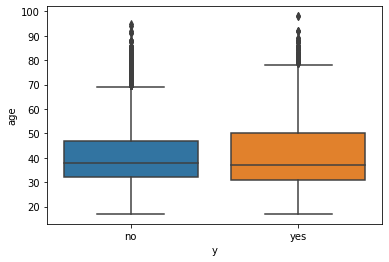

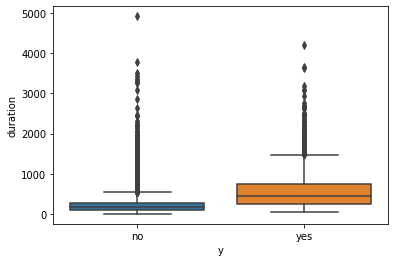

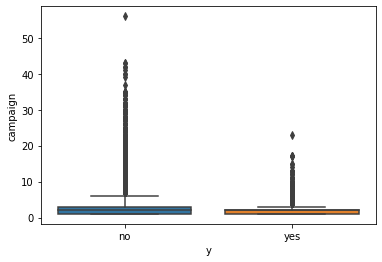

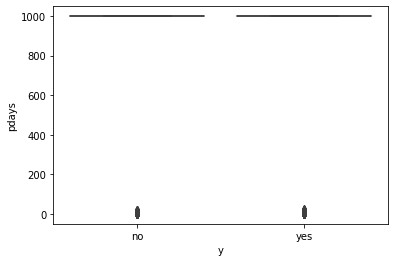

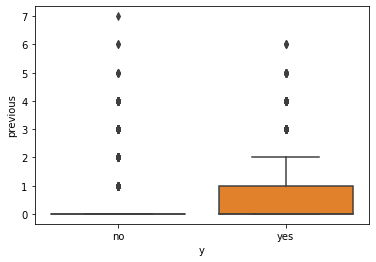

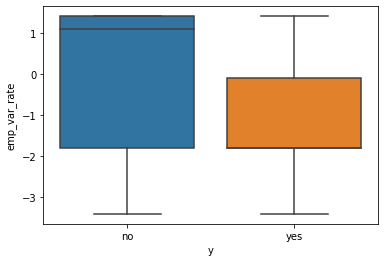

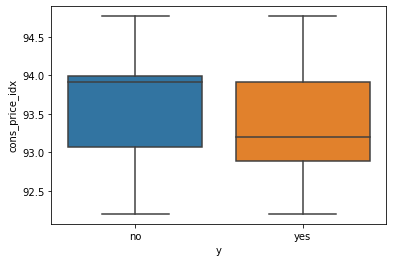

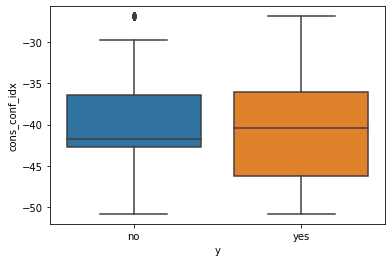

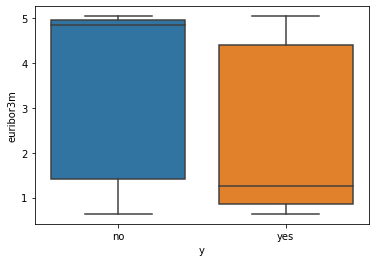

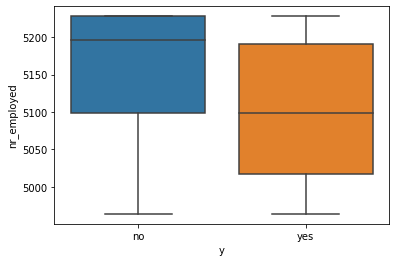

In [9]:
for columnName in fullDat.columns:
    if columnName == 'y':
        pass
    elif fullDat[columnName].dtype != object:
        plt.figure()
        plot = sns.boxplot(data = fullDat, x = 'y', y = columnName)

Much like the categorical data, there does appear to be good spread across the various numeric features against the target. The "previous" and "emp.var.rate" features both appear to have some distributional differences.

### Get dummies for non-numeric data

In [10]:
## Hold snapshot of data at this point for future reference
hold_fullDat = fullDat.copy()

In [11]:
## Convert categorical features
convert = ['job', 'marital', 'education', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
fullDat = pd.get_dummies(fullDat, columns = convert, drop_first = True)
fullDat.y = np.where(fullDat.y == 'yes', 1, 0)

### Train test split

Given the imbalanced nature of the target, the training and testing data will be stratified across the target, assuming that future data will hold this imbalance. Given there is relatively good volume, I will split the data 75/25.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(fullDat.drop('y', axis = 1), fullDat.y,
                                                    stratify = fullDat.y, 
                                                    random_state = 1029,
                                                    test_size = 0.25)

In [13]:
## Create dictionary to track model results
results = {}

def add_results(y_pred, model_name):
    ## Add results of test data to tracker, with user input to ensure data is overwritten on purpose
    if model_name in results.keys():
        userIn = input("Model already in dictionary. Add? ").lower()
        if userIn == 'yes':
            results[model_name] = metrics.roc_auc_score(y_test, y_pred)
        else:
            pass
    else:
        results[model_name] = metrics.roc_auc_score(y_test, y_pred)
    print(results)

### Model Build - Logistic Model

Begin with a simple logistic model to form a benchmark before moving on to more complicated model structures.

In [14]:
base_model = sm.Logit(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.207026
         Iterations 8


In [15]:
## Grab predictions for the positive class
add_results(base_model.predict(X_test), "baseLM")

{'baseLM': 0.9347362750166999}


In [16]:
base_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                30891
Model:                          Logit   Df Residuals:                    30841
Method:                           MLE   Df Model:                           49
Date:                Sun, 15 Nov 2020   Pseudo R-squ.:                  0.4119
Time:                        18:45:46   Log-Likelihood:                -6395.3
converged:                       True   LL-Null:                       -10875.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
age                               0.0003      0.004      0.082      0.934      -0.007       0.008
duration                          0.0048   8.14e-05     58.488      0.000       0.005       0.005
campaign                         -0.0518      0.013     -3.924      0.000      -0.078      -0.026
pdays                            -0.0010      0.000     -4.077      0.000      -0.001      -0.001
previous                         -0.0219      0.075     -0.291      0.771      -0.169       0.126
emp_var_rate                     -1.1052      0.099    -11.115      0.000      -1.300      -0.910
cons_price_idx                    0.6755      0.048     14.018      0.000       0.581       0.770
cons_conf_idx                    -0.0060      0.007     -0.865      0.387      -0.020       0.008
euribor3m                         0.8175      0.124      6.607      0.000       0.575       1.060
nr_employed                      -0.0135      0.001    -13.992      0.000      -0.015      -0.012
job_blue-collar                  -0.2471      0.092     -2.681      0.007      -0.428      -0.066
job_entrepreneur                 -0.0682      0.141     -0.484      0.629      -0.345       0.208
job_housemaid                    -0.0793      0.178     -0.446      0.656      -0.428       0.269
job_management                   -0.1214      0.099     -1.220      0.222      -0.316       0.074
job_retired                       0.2775      0.123      2.251      0.024       0.036       0.519
job_self-employed                -0.2161      0.141     -1.529      0.126      -0.493       0.061
job_services                     -0.1539      0.101     -1.532      0.126      -0.351       0.043
job_student                       0.1453      0.128      1.137      0.256      -0.105       0.396
job_technician                   -0.0760      0.082     -0.925      0.355      -0.237       0.085
job_unemployed                   -0.1168      0.153     -0.763      0.445      -0.417       0.183
job_unknown                      -0.1129      0.281     -0.402      0.688      -0.664       0.438
marital_married                  -0.0550      0.079     -0.701      0.483      -0.209       0.099
marital_single                    0.0161      0.090      0.179      0.858      -0.160       0.193
marital_unknown                   0.1095      0.468      0.234      0.815      -0.807       1.026
education_basic.6y                0.0562      0.142      0.395      0.693      -0.223       0.335
education_basic.9y                0.0583      0.110      0.531      0.596      -0.157       0.274
education_high.school             0.1201      0.106      1.136      0.256      -0.087       0.327
education_illiterate              1.5440      0.845      1.828      0.068      -0.112       3.200
education_professional.course     0.1877      0.117      1.609      0.108      -0.041       0.416
education_university.degree       0.2416      0.106      2.276      0.023       0.034       0.450
educati

### Model Build - Logistic Model - Drop Insignficant

In the event of overfitting, test the impact of removing insignificant features from the model.

In [17]:
## Dropping any features that are fully insignficant then iterating until all features are signficant. 
## Using a manual, iterative approach - using 0.05 p-value as threshold
drop_vars = ['age', 'previous', 'housing_unknown', 'loan_unknown', 'day_of_week_wed', 'housing_yes',
            'cons_conf_idx', 'marital_married', 'marital_single', 'marital_unknown', 'day_of_week_tue',
            'day_of_week_thu', 'education_basic.6y', 'education_basic.9y', 'loan_yes', 'education_unknown',
            'education_professional.course', 'job_unknown', 'month_jun', 'month_dec', 'job_technician',
            'job_entrepreneur', 'education_high.school', 'job_housemaid', 'job_management', 'job_services',
            'job_unemployed', 'education_illiterate', 'job_self-employed', 'month_sep', 'month_oct']

In [18]:
drop_dat = fullDat.drop(drop_vars, axis = 1)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(drop_dat.drop('y', axis = 1), drop_dat.y,
                                                    stratify = drop_dat.y, 
                                                    random_state = 1029,
                                                    test_size = 0.25)

In [20]:
model_iter = sm.Logit(y_train, X_train).fit()
model_iter.summary()

Optimization terminated successfully.
         Current function value: 0.207436
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                30891
Model:                          Logit   Df Residuals:                    30871
Method:                           MLE   Df Model:                           19
Date:                Sun, 15 Nov 2020   Pseudo R-squ.:                  0.4107
Time:                        18:45:47   Log-Likelihood:                -6407.9
converged:                       True   LL-Null:                       -10875.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
duration                        0.0048   8.62e-05     55.146      0.000       0.005       0.005
campaign                       -0.0534      0.014     -3.916      0.000      -0.080      -0.027
pdays                          -0.0010      0.000     -4.024      0.000      -0.001      -0.000
emp_var_rate                   -0.9539      0.067    -14.207      0.000      -1.086      -0.822
cons_price_idx                  0.6026      0.035     17.057      0.000       0.533       0.672
euribor3m                       0.6326      0.082      7.712      0.000       0.472       0.793
nr_employed                    -0.0120      0.001    -17.372      0.000      -0.013      -0.011
job_blue-collar                -0.2267      0.070     -3.253      0.001      -0.363      -0.090
job_retired                     0.2875      0.092      3.118      0.002       0.107       0.468
job_student                     0.2442      0.114      2.151      0.031       0.022       0.467
education_university.degree     0.1409      0.053      2.651      0.008       0.037       0.245
contact_telephone              -0.4473      0.078     -5.747      0.000      -0.600      -0.295
month_aug                       0.4789      0.083      5.781      0.000       0.317       0.641
month_jul                       0.2992      0.086      3.493      0.000       0.131       0.467
month_mar                       1.5848      0.123     12.878      0.000       1.344       1.826
month_may                      -0.6035      0.070     -8.569      0.000      -0.742      -0.465
month_nov                      -0.4748      0.094     -5.032      0.000      -0.660      -0.290
day_of_week_mon                -0.1907      0.059     -3.224      0.001      -0.307      -0.075
poutcome_nonexistent            0.5070      0.074      6.845      0.000       0.362       0.652
poutcome_success                0.9152      0.240      3.821      0.000       0.446       1.385
===============================================================================================
"""

In [21]:
add_results(model_iter.predict(X_test), "reductedLM")
## Small performance decrease from the reduced model but this is expected given we are offering fewer parameters

{'baseLM': 0.9347362750166999, 'reductedLM': 0.9345776267770679}


### LASSO Model

Test the difference between the final model and a LASSO regression. 

In [22]:
X_train, X_test, y_train, y_test = train_test_split(fullDat.drop('y', axis = 1), fullDat.y,
                                                    stratify = fullDat.y, 
                                                    random_state = 1029,
                                                    test_size = 0.25)

In [23]:
regularizedLogit = sm.Logit(y_train, X_train).fit_regularized()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.20702649281933647
            Iterations: 281
            Function evaluations: 301
            Gradient evaluations: 281


In [24]:
add_results(regularizedLogit.predict(X_test), "LASSO")
## Slight improvement from the LASSO model

{'baseLM': 0.9347362750166999, 'reductedLM': 0.9345776267770679, 'LASSO': 0.9347372185090558}


### XGBoost Model - Base

Run data through a base XGBoost model prior to hyper parameter tuning. Using `scale_pos_weight` to account for the imbalance in classes

In [25]:
XGBClassify = xgb.XGBClassifier(objective = 'binary:logistic', max_depth = 3, eta = .02, n_estimators = 100, 
                                seed = 100, eval_metric = 'auc',
                                scale_pos_weight = (len(y_train) - y_train.sum())/y_train.sum()).fit(X_train, 
                                                                                                     y_train)


In [26]:
add_results(XGBClassify.predict_proba(X_test)[:,1], "XGB_Base")

{'baseLM': 0.9347362750166999, 'reductedLM': 0.9345776267770679, 'LASSO': 0.9347372185090558, 'XGB_Base': 0.9366257599830926}


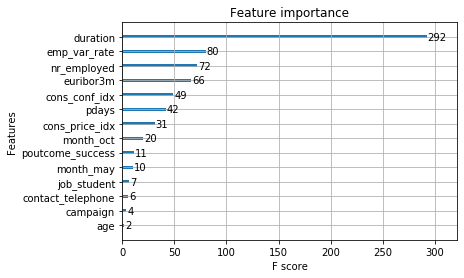

In [27]:
xgb.plot_importance(XGBClassify)

### Hypertuning the XGBoost model

Relaying on https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/ for a Python implementation of the hyperparameter grid search that I'm familiar with in R's `mlr` package.

In [29]:
param_test = {
 'max_depth':range(2,5,1),
 'min_child_weight':range(1,10,2),
 'subsample':[i/100.0 for i in range(75,90,5)]
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(objective = 'binary:logistic', eta = .02, 
                                                  n_estimators = 100, 
                                seed = 100, 
                                scale_pos_weight = (len(y_train) - y_train.sum())/y_train.sum()), 
 param_grid = param_test, scoring = 'roc_auc', iid = False, cv = 5)
gsearch1.fit(X_train, y_train)
gsearch1.best_estimator_

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.02, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.0199999996, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=100, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=7.876724137931035, seed=100,
              subsample=0.75, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [30]:
## Select final number of estimators
params = {'eta': 0.02, 'seed': 100, 'scale_pos_weight':(len(y_train) - y_train.sum())/y_train.sum(),
         'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.75, 'objective': 'binary:logistic',
          'eval_metric': 'auc'}


CVRun = xgb.cv(
            params = params,
            dtrain = xgb.DMatrix(X_train, label = y_train),
            num_boost_round = 500,
            nfold = 5,
            metrics = 'auc',
            seed = 100)


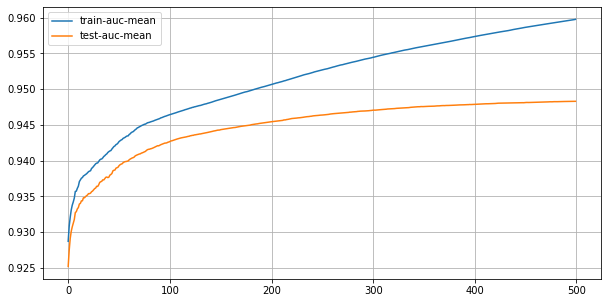

In [31]:
CVRun.drop(['train-auc-std', 'test-auc-std'], axis = 1, inplace = True)
CVRun.plot(figsize = (10,5), grid = True)

In [32]:
## Selected 400 as the number of rounds to avoid over fitting
XGB_hyperparam = xgb.train(params, xgb.DMatrix(X_train, label = y_train), 400)

In [33]:
add_results(XGB_hyperparam.predict(xgb.DMatrix(X_test)), "XGB_Hyperparam")

{'baseLM': 0.9347362750166999, 'reductedLM': 0.9345776267770679, 'LASSO': 0.9347372185090558, 'XGB_Base': 0.9366257599830926, 'XGB_Hyperparam': 0.9486426918969102}


### Takeaways

The more complex model does provide a better fit when compared to the base logistic model, even LASSO. Hyperparameter tuning was quite important, likely as a result of not selecting an optimal number of rounds in the base XGB model.

Next steps when I revisit this project would be to examine the impact on the XGBoost model structure when adding some interpolation (maybe `MICE`) techniques to the unknown data. I would also want to examine the performance using Random Forest, SVM and a Sequential model.